# <U>Notebook Table Of Contents<u>
    
**1. Imbalanced Dataset**<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.1 Support Vector Machine<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1.1 Using balanced class weights to handle class imbalance<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.2 Random Forest<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.2.1 Using balanced class weights to handle class imbalance<br>
**2. Using Balanced Dataset**<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.1 Support Vector Machine<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.2 Random Forest<br>
**3. Regression Models**<br>
&nbsp;&nbsp;&nbsp;&nbsp;3.1 SVM - regression<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1.1 Using balanced dataset<br>
&nbsp;&nbsp;&nbsp;&nbsp;3.2 Random Forest- Regression<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1 Using balanced dataset<br>
**4. Performing Stratified K-fold Cross Validation on all Models**<br>
**5. Saving models**<br>

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## plotting modules
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 

#Machine Learning
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.svm import SVC, SVR
from scikeras.wrappers import KerasClassifier
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

#importing tensorflow and keras packages
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

#importing packages to save ml models
from joblib import dump, load

#stats modules
from scipy.stats import randint

#supressing warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
##load in cleaned and processed data
sub_class_data = pd.read_csv('../data/derived_tables/X_y_data/sub_class_data.csv', index_col=0)

#splitting into independent/input (X) and dependent/target (Y) variables
X = sub_class_data.loc[:, sub_class_data.columns != 'sub_class']
y = sub_class_data.loc[:, 'sub_class']

In [3]:
class_order = set(y)

In [4]:
## splitting the data into training and testing (80% used for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 1, 
                                                    stratify = y)

In [99]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1744, 3508), (436, 3508), (1744,), (436,))

**Defining some functions to help removing repeated code when evaluating models:**

In [5]:
#defining function for evaluating metrics 
def get_metrics(model, X_train, X_test, y_train, y_test, class_type='class'):
    #making predictions from the model on the train and test data
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)
    
    #if ordinal classification (i.e. regression used) the predictions need to be converted to class lables
    if class_type == 'reg':
        #reshaping predictions in a 1D array
        y_preds_train = y_preds_train.flatten()
        y_preds_test = y_preds_test.flatten()
        #converting continuous predictions to predicted class labels
        y_preds_train = np.round(y_preds_train).astype(int)
        #clipping to ensure predicted class is within the range of available classes
        y_preds_train = np.clip(y_preds_train, 0, len(class_order) - 1)

        y_preds_test = np.round(y_preds_test).astype(int)
        y_preds_test = np.clip(y_preds_test, 0, len(class_order) - 1)
    
    #calculating metrics
    # F1-score
    test_f1 = metrics.f1_score(y_test, y_preds_test, average='weighted')
    train_f1 = metrics.f1_score(y_train, y_preds_train, average='weighted')
    
    #accuracy
    test_accuracy = metrics.accuracy_score(y_test, y_preds_test)
    train_accuracy =  metrics.accuracy_score(y_train, y_preds_train)

    #quadratic weighted kappa
    test_qwk = metrics.cohen_kappa_score(y_test, y_preds_test, weights='quadratic')
    train_qwk = metrics.cohen_kappa_score(y_train, y_preds_train, weights='quadratic')
    #mean absolute error
    test_mae = metrics.mean_absolute_error(y_test, y_preds_test)
    train_mae =  metrics.mean_absolute_error(y_train, y_preds_train)
    
    #getting the class error for test set
    average_error = np.mean(abs(y_test - y_preds_test))
    
    model_metrics = pd.DataFrame({'model':[str(model)], 
                                  'accuracy':[test_accuracy], 
                                  'f1_score':[test_f1],
                                  'QWK':[test_qwk], 
                                  'MAE':[test_mae],
                                   'sp_class_error':[average_error]})

    return model_metrics, y_preds_train, y_preds_test

In [7]:
#defining function to plot scatter plot
def plot_scatter_plot(y_test, y_pred, model_name):
    #adding 5 to each prediction due to 5 missing classes (i.e O0 - O4) when encoding
    class_results = pd.DataFrame({'actual_sub_class':y_test + 5, 
                                       'predicted_sub_class':y_pred + 5})
    
    #determining the density of each prediction/actual combintation 
    results = class_results.groupby(['actual_sub_class', 'predicted_sub_class']).size().reset_index(name='counts')
    
    plt.figure(figsize=(12,8))
    
    scatter_plot = sns.scatterplot(data=results, x='predicted_sub_class', y='actual_sub_class',
                                   hue='counts',palette='dark:blue_r', label='predictions', legend=None)
    
    plt.plot([0,70],[0,70],
             color='red', linestyle='--', linewidth=1, label='true positive diagonal')
    
    mk_classes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
    tick_positions = [0, 10, 20, 30, 40, 50, 60]
    plt.xticks(tick_positions, mk_classes)
    plt.yticks(tick_positions, mk_classes)
    
    plt.title(f'Scatter plot of actual sub-class vs predicted sub-class : {model_name}', fontsize=15)
    plt.ylabel('Actual sub class', fontsize=15)
    plt.xlabel('Predicted sub class', fontsize=15)
    plt.legend(loc=(1.01,0.9))
    plt.grid(True, alpha = 0.4)
    plt.xlim(0,70)
    plt.ylim(0,70)
    plt.show()

## Using best model types from *ML_main_class_classification_models.ipynb*:
### 1) Support Vector Machine 
### 2) Random Forests
- Trying both classification and regression versions. 
- Using balanced dataset for classification.

# 1. <U> Imbalanced Dataset:

## 1.1 Support Vector Machine

In [102]:
#looking at training and testing data shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1744, 3508), (436, 3508), (1744,), (436,))

In [103]:
# Create an object svmModel by calling a method SVC() - using default hyperparameters
#kernel = 'rbf',C = 1, gamma = 'scale'
svm_1 = SVC()

In [104]:
# Train the model by calling a method fit()
svm_1.fit(X_train,y_train)

SVC()

In [107]:
svm1_metrics, y_preds_train_svm1, y_preds_test_svm1 = get_metrics(svm_1,
                                                                  X_train, X_test, y_train, y_test)

In [108]:
svm1_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,SVC(),0.240826,0.13862,0.977626,2.112385,2.112385


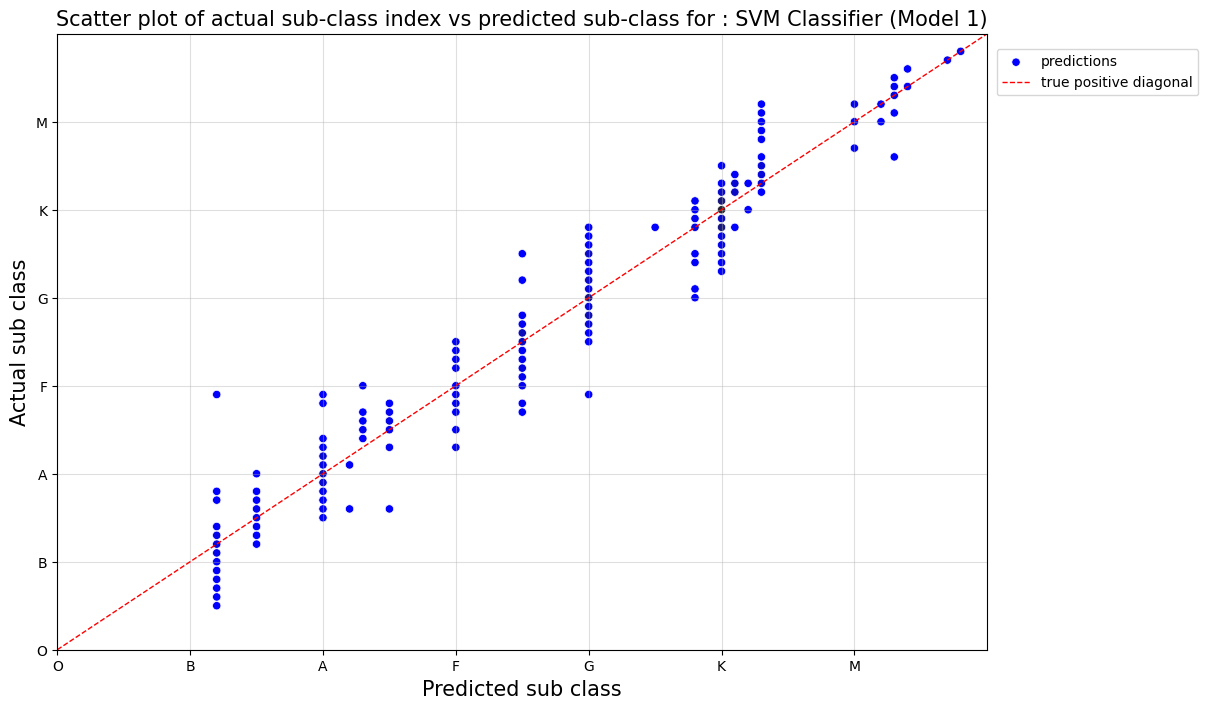

In [213]:
plot_scatter_plot(y_test, y_preds_test_svm1, 'SVM Classifier (Model 1)')

**NOTE**: the red line in the above visualisation represents the true positive cases i.e. where the predicted class = actual class, essentially illustrating the diagonal on the confusion matrix

#### hyperparameter tuning - SVM

- **Kernel**: The mathematical function, which is used in SVM to map the original input data points into high-dimensional feature spaces, so, that the hyperplane can be easily found out even if the data points are not linearly separable in the original input space. Some of the common kernel functions are linear, polynomial, radial basis function(RBF), and sigmoid. RBF or gaussian kernal is a popular choice for complex non-linear data ref: https://www.geeksforgeeks.org/support-vector-machine-algorithm/<br>
more on kernals: https://www.geeksforgeeks.org/major-kernel-functions-in-support-vector-machine-svm/ <br>
<br>
- **C**: Regularization parameter; trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. A stricter penalty is imposed with a greater value of C, which results in a smaller margin and perhaps fewer misclassification.
ref: https://scikit-learn.org/stable/modules/svm.html#kernel-functions
<br>

- **gamma**:Defines how much influence a single training example has. A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting.a low value of gamma considers only nearby points in calculating the separation line, while the a value of gamma considers all the data points in the calculation of the separation line. ref: https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python
<br>

- Notes from https://www.linkedin.com/advice/0/how-do-you-optimize-hyperparameters-svm#:~:text=SVM%20hyperparameters%20are%20the%20settings,decision%20boundary%20can%20be%20found.:  "use a logarithmic scale for C and gamma values to capture the wide range of possible values and reflect their relative importance."

In [14]:
#using grid search CV
#defining parameter range 
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 'scale'], 
              'kernel': ['rbf', 'poly'], 
               'degree': [2, 3]}  
  
grid_search_svc = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0) 
  
# fitting the model for grid search 
grid_search_svc.fit(X_train, y_train)

In [20]:
# print best parameter after tuning 
print(grid_search_svc.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid_search_svc.best_estimator_) 

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, gamma=0.01)


In [115]:
#initialising model with tuned parameters
svm_2 = SVC(C=100, gamma=0.01, kernel='rbf')

In [116]:
# Train the model by calling a method fit()
svm_2.fit(X_train, y_train)

SVC(C=100, gamma=0.01)

In [117]:
svm2_metrics, y_preds_train_svm2, y_preds_test_svm2 = get_metrics(svm_2, 
                                                    X_train, X_test, y_train, y_test)

In [118]:
svm2_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"SVC(C=100, gamma=0.01)",0.527523,0.51131,0.981603,1.100917,1.100917


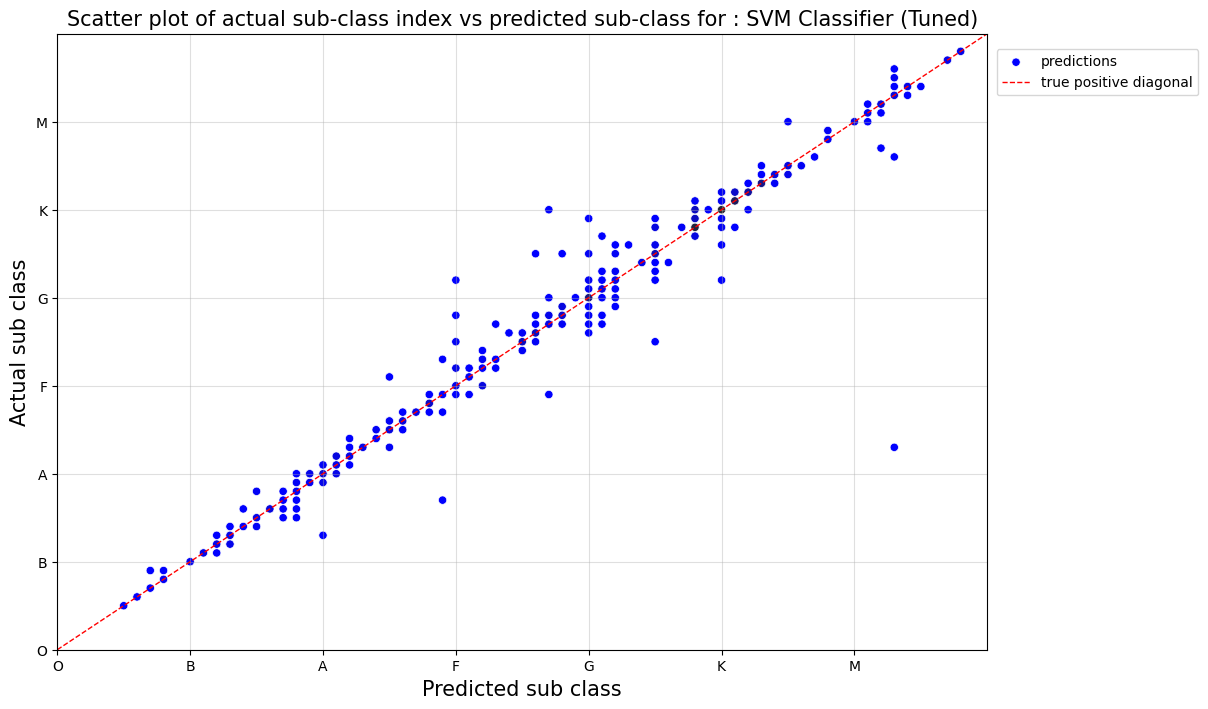

In [214]:
plot_scatter_plot(y_test, y_preds_test_svm2, 'SVM Classifier (Tuned)')

### 1.1.1 Using balanced class weights to handle class imbalance:

In [120]:
#initialising model with tuned parameters
svm_cl_weights = SVC(C=100, gamma=0.01, kernel='rbf', class_weight='balanced')

# Train the model by calling a method fit()
svm_cl_weights.fit(X_train, y_train)

SVC(C=100, class_weight='balanced', gamma=0.01)

In [121]:
svm_cl_weights_metrics, y_preds_train_svm_weights, y_preds_test_svm_weights = get_metrics(svm_cl_weights, 
                                                                  X_train, X_test, y_train, y_test)

In [122]:
svm_cl_weights_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"SVC(C=100, class_weight='balanced', gamma=0.01)",0.474771,0.478976,0.980686,1.178899,1.178899


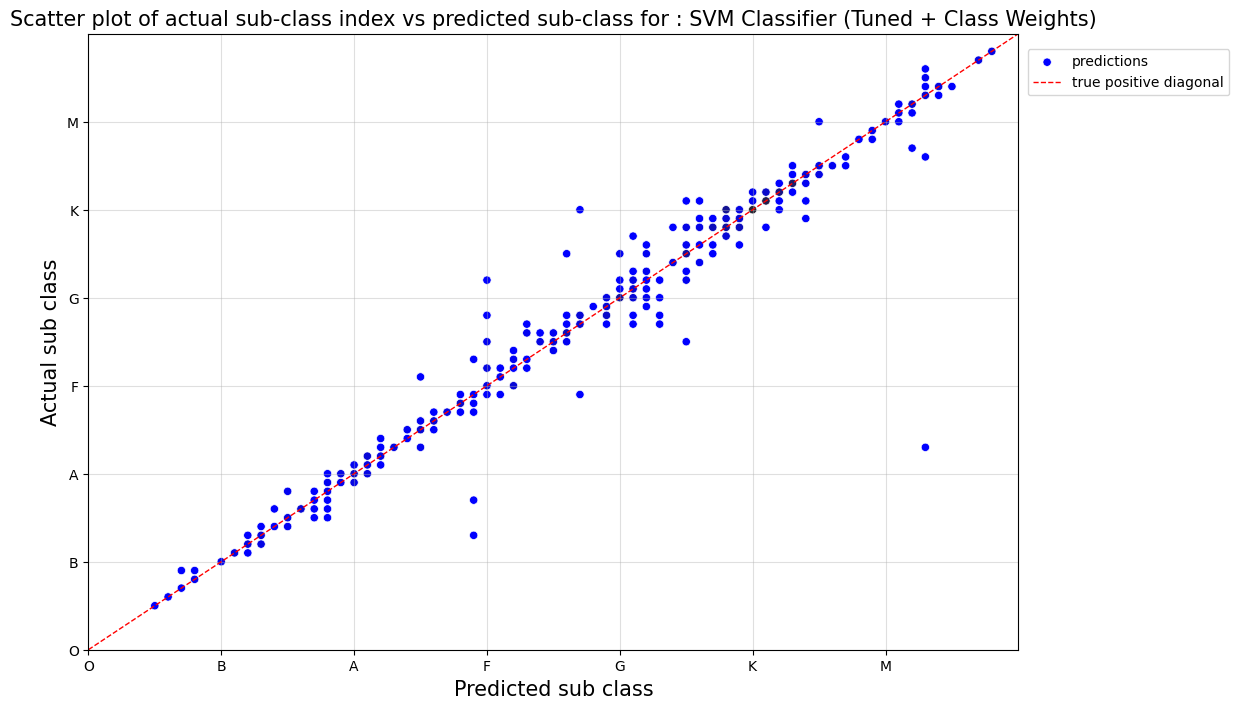

In [215]:
plot_scatter_plot(y_test, y_preds_test_svm_weights, 'SVM Classifier (Tuned + Class Weights)')

-------
## 1.2 Random Forest

In [124]:
# Create a Random Forest Classifier
rf_1 = RandomForestClassifier(random_state=42)

#training the model using X_train, y_train
rf_1.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [125]:
rf1_metrics, y_preds_train_rf1, y_preds_test_rf1 = get_metrics(rf_1, 
                                                  X_train, X_test, y_train, y_test)

In [126]:
rf1_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,RandomForestClassifier(random_state=42),0.490826,0.481379,0.991162,1.03211,1.03211


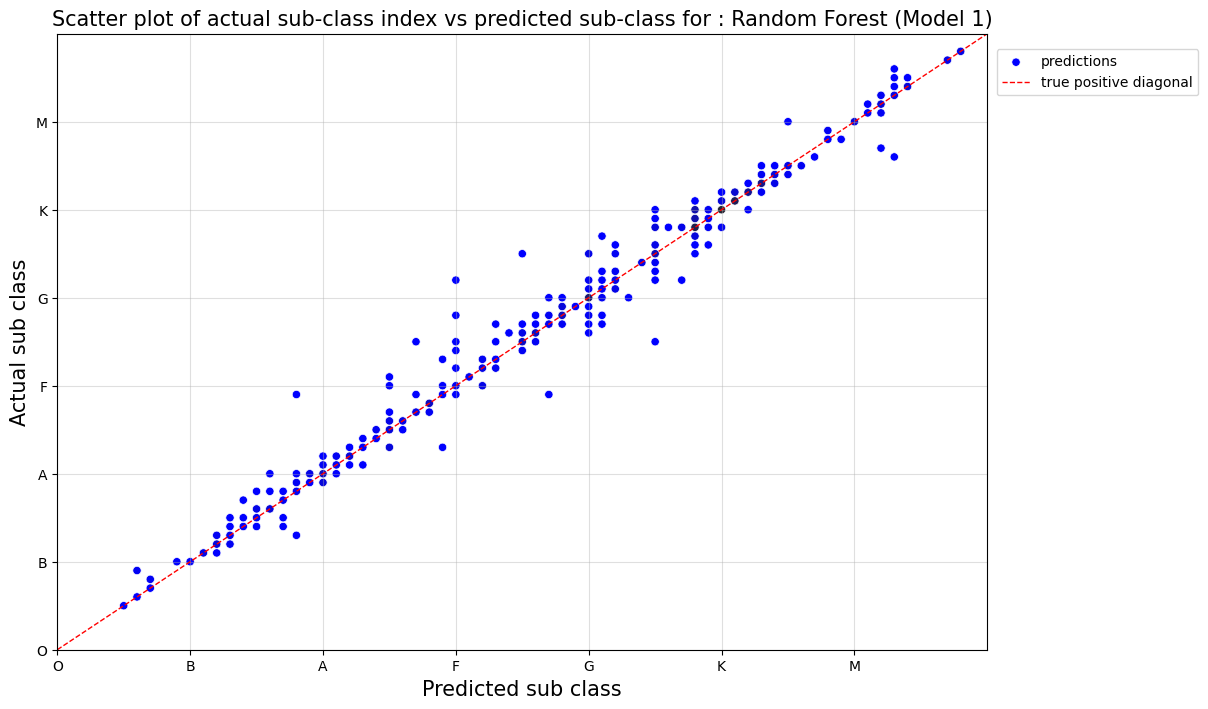

In [216]:
plot_scatter_plot(y_test, y_preds_test_rf1, 'Random Forest (Model 1)')

##### Hyperparameter tuning - Random Forest

There are some hyperparameters that may be tuned to improve the model accuracy. 
The most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features).
<br>
The hyperparameters that will be tuned as part of this research project are: <br>
- a) **n_estimators** : the number of decision trees in the forest
- b) **max_depth** : the maximum depth of each decision tree in the forest
- c) **max_features** : max number of features considered for splitting a node
- d) **min_samples_split**: min number of data points placed in a node before the node is split
- e) **min_samples_leaf**: min number of data points allowed in a leaf node



In [62]:
##defining hyperparameter space to iterate through - might want to outline reason for below choices
param_grid = {'n_estimators':[10, 100, 200, 500, 1000], #number of trees (default = 100)
              'max_depth': [None, 5, 10, 20, 50], #max depth of tree (default = None)
              'max_features': ['sqrt', 'log2'],  #num features to consider when looking for best split
              'min_samples_leaf': [1, 2, 4] , 
              'min_samples_split': [2, 5, 10]
              } 

#Create a random forest classifier
rf = RandomForestClassifier()

#running gridSearch on params, with the default k-fold cross validation set to 3
grid_search_rf = GridSearchCV(estimator=rf, 
                              param_grid=param_grid, 
                              cv=3,  # 3-fold cross-validation
                              verbose=0) 

#Fit the grid search object to the data
grid_search_rf.fit(X_train, y_train)

In [63]:
## Create a variable for the best model
best_rf = grid_search_rf.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  grid_search_rf.best_params_)

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}


In [128]:
rf_2 = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                              min_samples_leaf=1, max_features='sqrt', random_state=42)

In [129]:
rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)

In [130]:
rf2_metrics, y_preds_train_rf2, y_preds_test_rf2 = get_metrics(rf_2, 
                                                  X_train, X_test, y_train, y_test)

In [131]:
rf2_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"RandomForestClassifier(max_depth=10, n_estimat...",0.502294,0.489637,0.991907,1.006881,1.006881


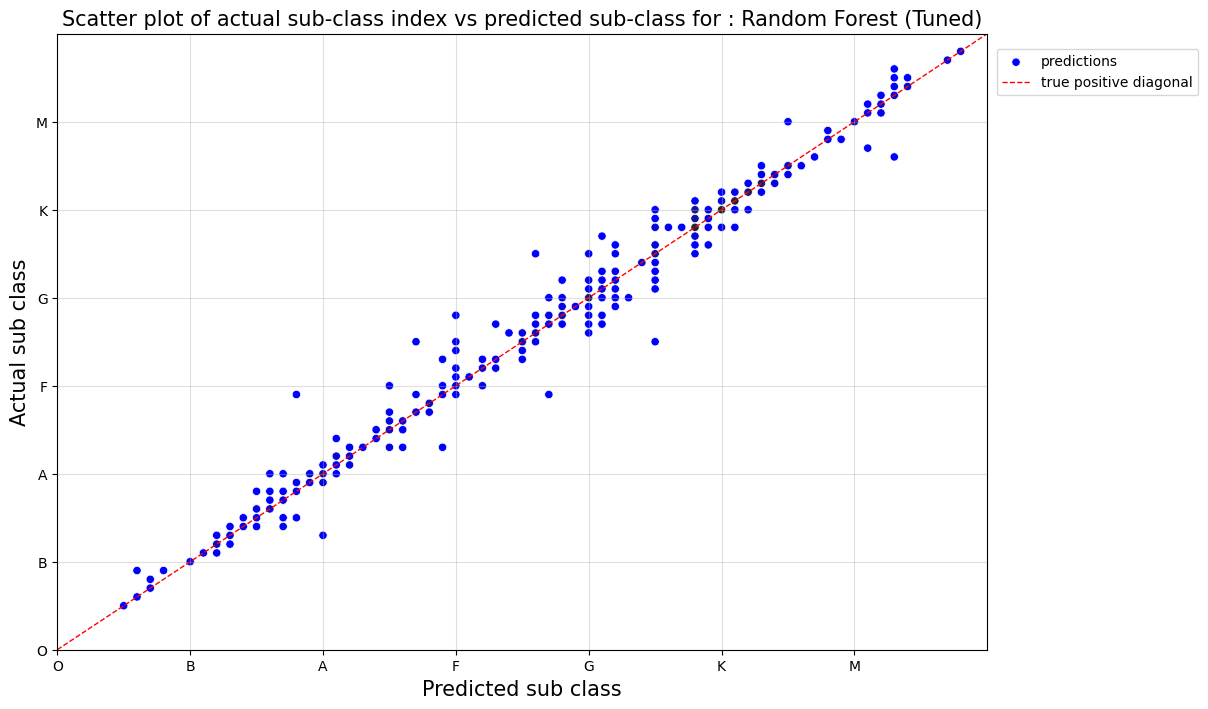

In [217]:
plot_scatter_plot(y_test, y_preds_test_rf2, 'Random Forest (Tuned)')

### 1.2.1 Using balanced class weights to handle class imbalance:

In [133]:
#initialising model with tuned parameters
rf_cl_weights = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                                       min_samples_leaf=1, max_features='sqrt', random_state=4,
                                       class_weight='balanced')

# Train the model by calling a method fit()
rf_cl_weights.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=500,
                       random_state=4)

In [134]:
rf_cl_weights_metrics, y_preds_train_rf_weights, y_preds_test_rf_weights = get_metrics(rf_cl_weights, 
                                                                  X_train, X_test, y_train, y_test)

In [135]:
rf_cl_weights_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,RandomForestClassifier(class_weight='balanced'...,0.449541,0.453779,0.990769,1.135321,1.135321


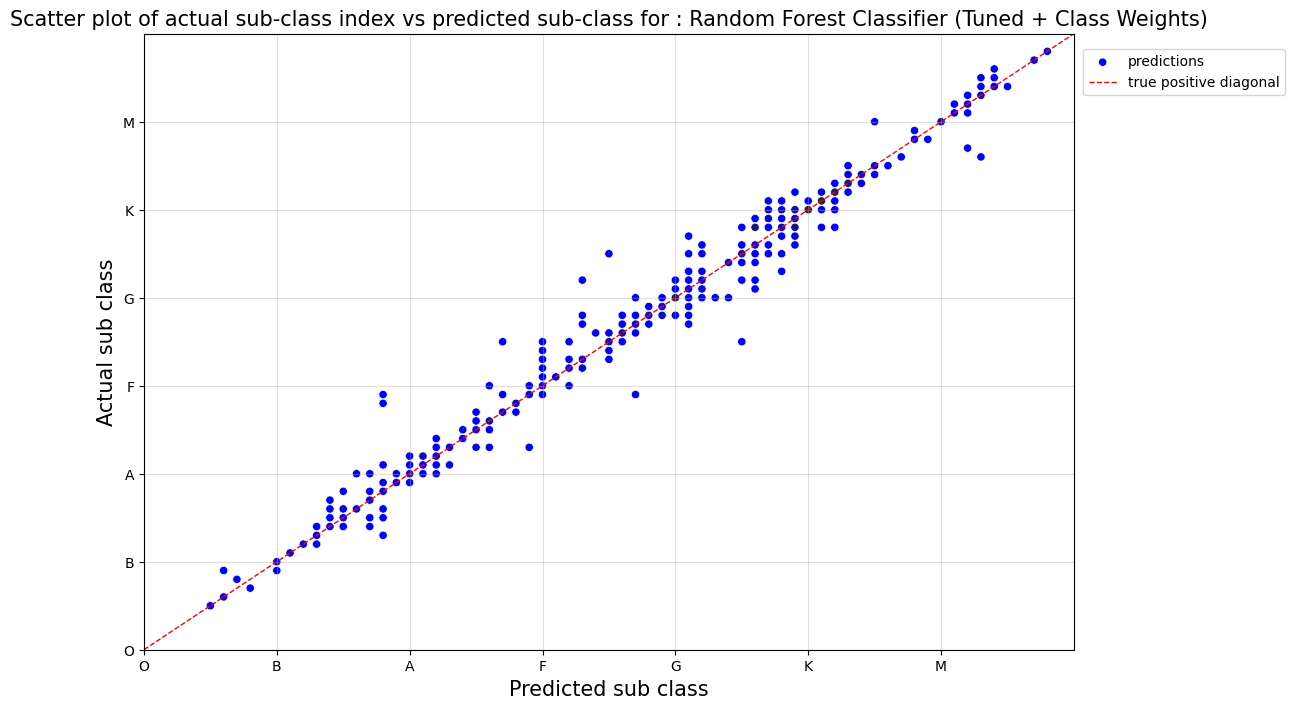

In [218]:
plot_scatter_plot(y_test, y_preds_test_rf_weights, 'Random Forest Classifier (Tuned + Class Weights)')

# 2. Using Balanced Dataset 
2 Methods:
- Using Class weights - https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
- Using undersampled/oversampled balanced data

In [8]:
##load in cleaned and processed balanced data
balanced_df = pd.read_csv('../data/derived_tables/X_y_data/sub_bal.csv', index_col=0)

In [9]:
#splitting into independent/input (X) and dependent/target (Y) variables
X_bal = balanced_df.loc[:, balanced_df.columns != 'sub_class']
y_bal = balanced_df.loc[:, 'sub_class']

In [10]:
y_bal = y_bal.values

In [11]:
#splitting the data into training and testing (80% used for training, 20% for testing)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, 
                                                                    test_size = 0.2, 
                                                                    random_state = 1)

In [12]:
X_train_bal.shape, X_test_bal.shape, y_train_bal.shape, y_test_bal.shape

((1740, 3508), (436, 3508), (1740,), (436,))

## 2.1 Support Vector Machine

In [40]:
#using grid search CV
#defining parameter range 
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 'scale'], 
              'kernel': ['rbf']}  
  
grid_search_svc = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0) 
  
# fitting the model for grid search 
grid_search_svc.fit(X_train, y_train)

In [41]:
# print best parameter after tuning 
print(grid_search_svc.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid_search_svc.best_estimator_) 

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, gamma=0.01)


In [13]:
#initialising model with tuned parameters
svm_bal = SVC(C=100, gamma=0.01, kernel='rbf')

In [14]:
# Train the model by calling a method fit()
svm_bal.fit(X_train_bal, y_train_bal)

SVC(C=100, gamma=0.01)

In [15]:
svm_bal_metrics, y_preds_train_svm_bal, y_preds_test_svm_bal = get_metrics(svm_bal, 
                                                    X_train_bal, X_test, y_train_bal, y_test)

In [16]:
svm_bal_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"SVC(C=100, gamma=0.01)",0.713303,0.708569,0.994972,0.568807,0.568807


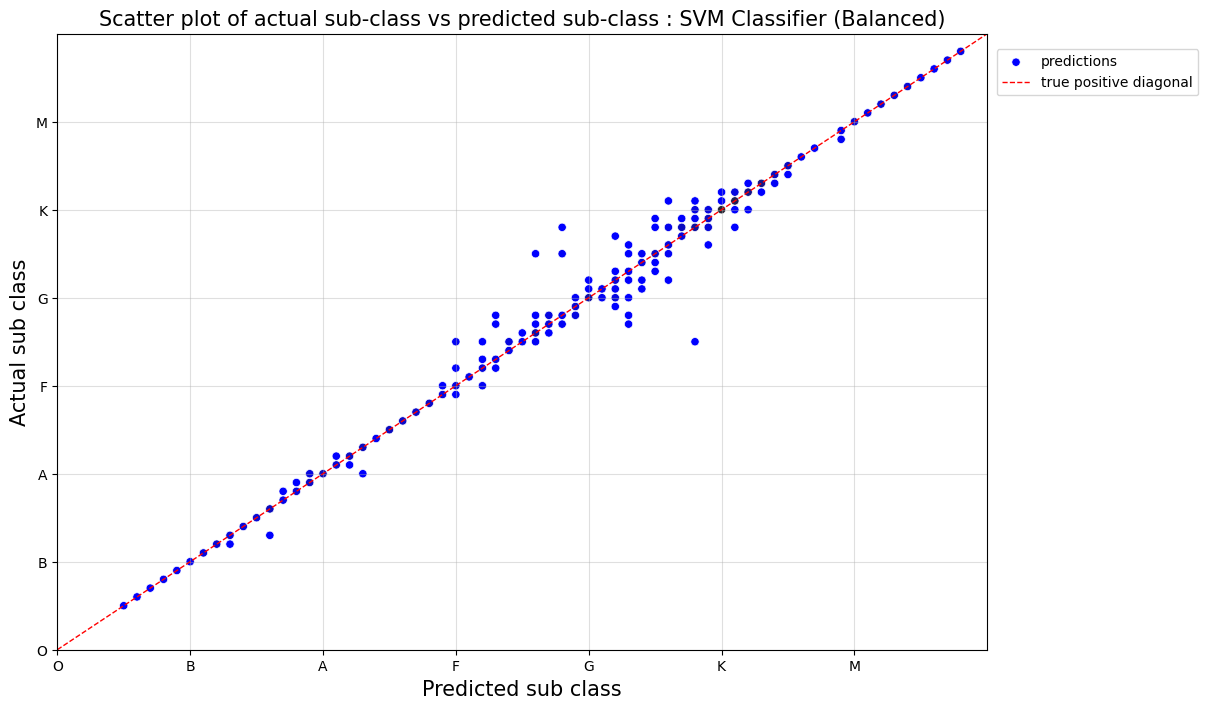

In [17]:
plot_scatter_plot(y_test, y_preds_test_svm_bal, 'SVM Classifier (Balanced)')

## 2.2 Random Forest

In [47]:
##defining hyperparameter space to iterate through - might want to outline reason for below choices
param_grid = {'n_estimators':[10, 100, 200, 500, 1000], #number of trees (default = 100)
              'max_depth': [None, 5, 10, 20, 50], #max depth of tree (default = None)
              'max_features': ['sqrt', 'log2'],  #num features to consider when looking for best split
              'min_samples_leaf': [1, 2, 4] , 
              'min_samples_split': [2, 5, 10]
              } 

#Create a random forest classifier
rf = RandomForestClassifier()

#running gridSearch on params, with the default k-fold cross validation set to 3
grid_search_rf = GridSearchCV(estimator=rf, 
                              param_grid=param_grid, 
                              cv=3,  # 3-fold cross-validation
                              verbose=0) 

#Fit the grid search object to the data
grid_search_rf.fit(X_train, y_train)

In [63]:
## Create a variable for the best model
best_rf = grid_search_rf.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  grid_search_rf.best_params_)

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}


In [147]:
rf_bal = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                                  min_samples_leaf=1, max_features='sqrt', random_state=42)

In [148]:
rf_bal.fit(X_train_bal, y_train_bal)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)

In [149]:
rf_bal_metrics, y_preds_train_rf_bal, y_preds_test_rf_bal = get_metrics(rf_bal, 
                                                  X_train_bal, X_test, y_train_bal, y_test)

In [150]:
rf_bal_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"RandomForestClassifier(max_depth=10, n_estimat...",0.724771,0.726864,0.995663,0.56422,0.56422


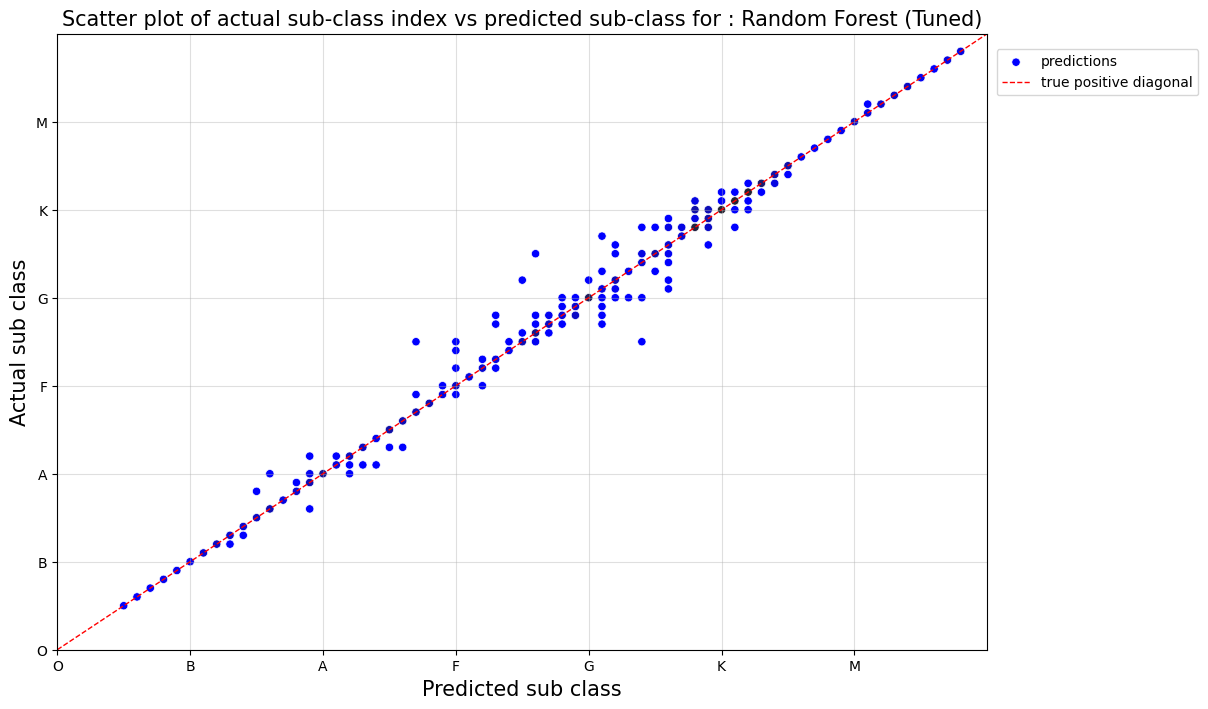

In [220]:
plot_scatter_plot(y_test, y_preds_test_rf_bal, 'Random Forest (Tuned)')

# 3. Regression Models

## 3.1 SVM - regression

In [162]:
#looking at training and testing data shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1744, 3508), (436, 3508), (1744,), (436,))

using the SVR() method for support vector regression: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [163]:
# Create an object svmModel by calling a method SVR() - using default hyperparameters
#kernel = 'rbf',C = 1, gamma = 'scale'
svm_reg1 = SVR()

In [164]:
# Train the model by calling a method fit()
svm_reg1.fit(X_train, y_train)

SVR()

In [174]:
svm_reg_metrics, y_preds_train_svr1, y_preds_test_svr1 = get_metrics(svm_reg1, 
                                                    X_train, X_test, y_train, y_test, 
                                                    class_type='reg')

In [175]:
svm_reg_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,SVR(),0.275229,0.277908,0.982367,1.770642,1.770642


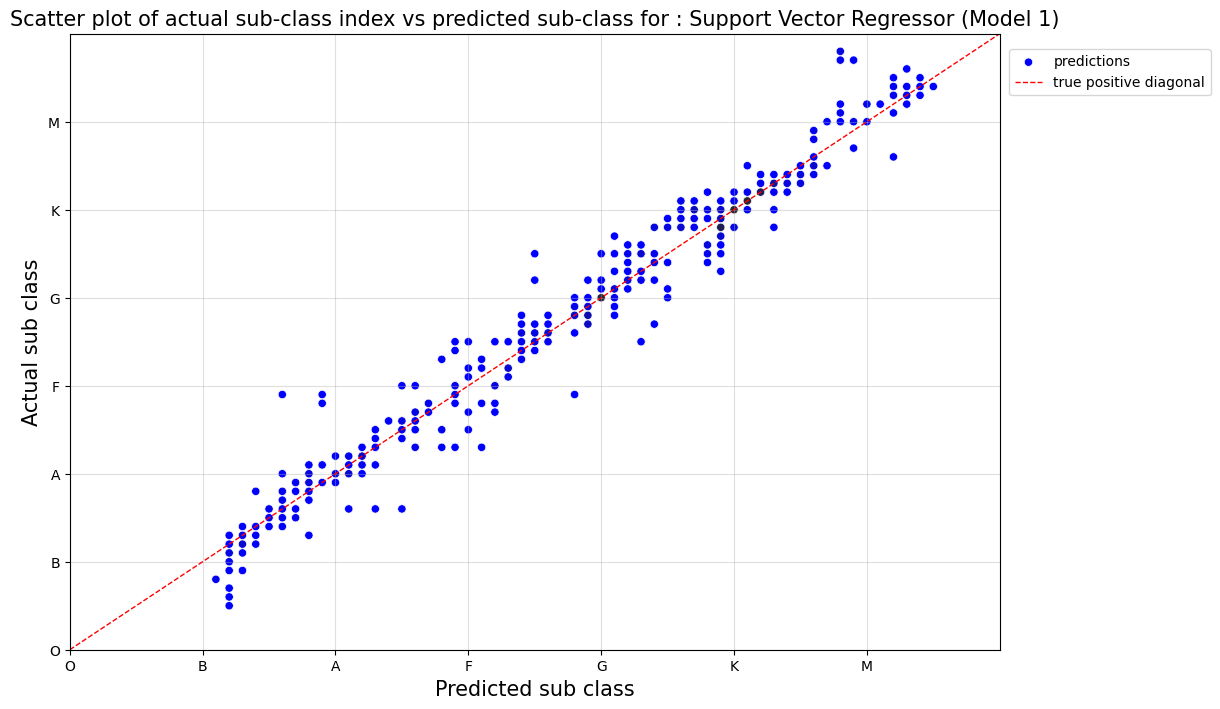

In [221]:
plot_scatter_plot(y_test, y_preds_test_svr1, 'Support Vector Regressor (Model 1)')

#### hyperparameter tuning - SVM

- **Kernel**: The mathematical function, which is used in SVM to map the original input data points into high-dimensional feature spaces, so, that the hyperplane can be easily found out even if the data points are not linearly separable in the original input space. Some of the common kernel functions are linear, polynomial, radial basis function(RBF), and sigmoid. RBF or gaussian kernal is a popular choice for complex non-linear data ref: https://www.geeksforgeeks.org/support-vector-machine-algorithm/<br>
more on kernals: https://www.geeksforgeeks.org/major-kernel-functions-in-support-vector-machine-svm/ <br>
<br>
- **C**: Regularization parameter; trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. A stricter penalty is imposed with a greater value of C, which results in a smaller margin and perhaps fewer misclassification.
ref: https://scikit-learn.org/stable/modules/svm.html#kernel-functions
<br>

- **gamma**:Defines how much influence a single training example has. A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting.a low value of gamma considers only nearby points in calculating the separation line, while the a value of gamma considers all the data points in the calculation of the separation line. ref: https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python
<br>

- Notes from https://www.linkedin.com/advice/0/how-do-you-optimize-hyperparameters-svm#:~:text=SVM%20hyperparameters%20are%20the%20settings,decision%20boundary%20can%20be%20found.:  "use a logarithmic scale for C and gamma values to capture the wide range of possible values and reflect their relative importance."

In [54]:
#using grid search CV to conduct tuning again 
#negative mean squared error (neg_mean_squared_error) by default for scoring
#defining parameter range 
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 'scale'], 
              'kernel': ['rbf'], 
               'epsilon':[0.001, 0.01, 0.1, 1, 10]} 

grid_search_svr = GridSearchCV(SVR(), param_grid, refit = True, verbose = 0) 
  
# fitting the model for grid search 
grid_search_svr.fit(X_train, y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [10, 100], 'epsilon': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.01, 0.001], 'kernel': ['rbf']})

In [178]:
# print best parameter after tuning 
#print(grid_search_svr.best_params_)   
# print how our model looks after hyper-parameter tuning 
#print(grid_search_svr.best_estimator_) 

In [179]:
#initialising model with tuned parameters
svm_reg2 = SVR(C=100, gamma=0.001, kernel='rbf', epsilon = 0.1)

In [180]:
# Train the model by calling a method fit()
svm_reg2.fit(X_train,y_train)

SVR(C=100, gamma=0.001)

In [181]:
svm2_reg_metrics, y_preds_train_svr2, y_preds_test_svr2 = get_metrics(svm_reg2,
                                                                    X_train, X_test, y_train, y_test,
                                                                    class_type='reg')

In [182]:
svm2_reg_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"SVR(C=100, gamma=0.001)",0.373853,0.3816,0.992013,1.073394,1.073394


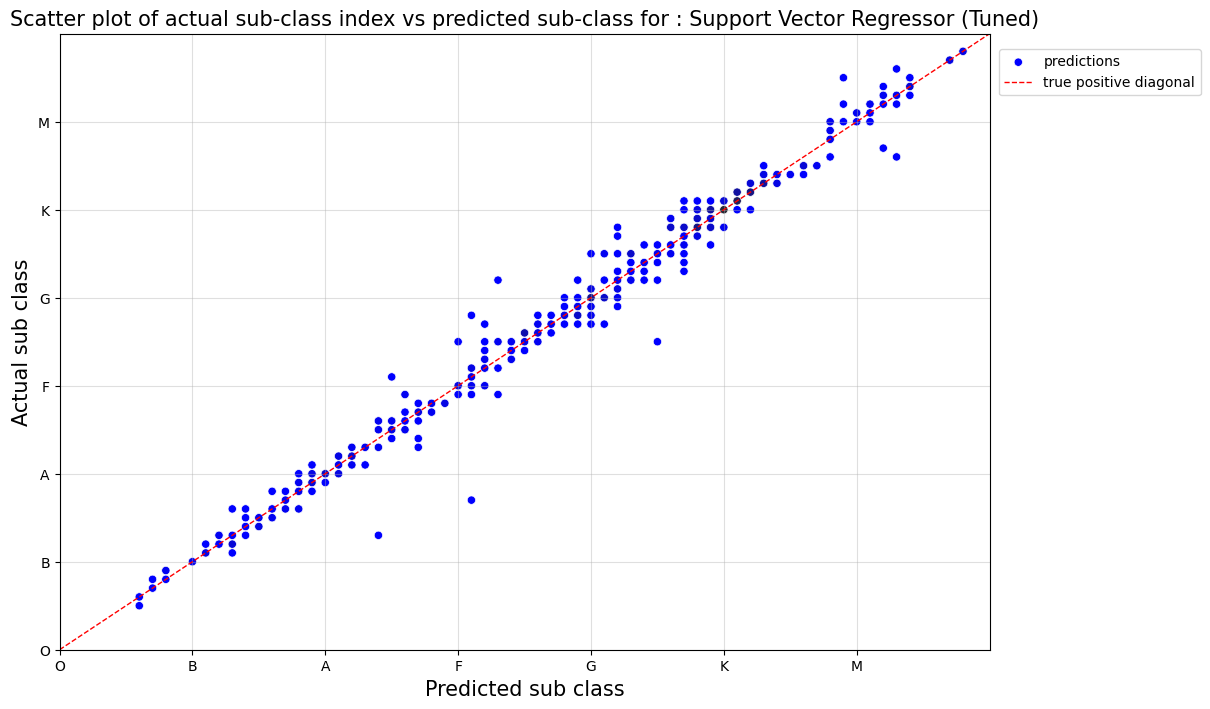

In [222]:
plot_scatter_plot(y_test, y_preds_test_svr2, 'Support Vector Regressor (Tuned)')

## 3.1.1 Using balanced dataset

In [184]:
##load in cleaned and processed balanced data
balanced_df = pd.read_csv('../data/derived_tables/X_y_data/sub_bal.csv', index_col=0)

In [185]:
#splitting into independent/input (X) and dependent/target (Y) variables
X_bal = balanced_df.loc[:, balanced_df.columns != 'sub_class']
y_bal = balanced_df.loc[:, 'sub_class']

In [186]:
y_bal = y_bal.values

In [187]:
#splitting the data into training and testing (80% used for training, 20% for testing)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, 
                                                                    test_size = 0.2, 
                                                                    random_state = 1)

In [188]:
X_train_bal.shape, X_test_bal.shape, y_train_bal.shape, y_test_bal.shape

((1740, 3508), (436, 3508), (1740,), (436,))

In [189]:
#initialising model with tuned parameters
svm_reg_bal = SVR(C=100, gamma=0.001, kernel='rbf', epsilon = 0.1)

In [190]:
# Train the model by calling a method fit()
svm_reg_bal.fit(X_train_bal,y_train_bal)

SVR(C=100, gamma=0.001)

In [191]:
svmbal_reg_metrics, y_preds_train_svr_bal, y_preds_test_svr_bal = get_metrics(svm_reg_bal,
                                                                    X_train_bal, X_test, y_train_bal, y_test,
                                                                    class_type='reg')

In [192]:
svmbal_reg_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"SVR(C=100, gamma=0.001)",0.451835,0.4568,0.993496,0.942661,0.942661


# 3.2 Random Forest- Regression

In [193]:
# Create a Random Forest Regressor
rf_reg_1 = RandomForestRegressor(random_state=42)

#training the model using X_train, y_train
rf_reg_1.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [194]:
rf1_reg_metrics, rfy_preds_train_rf_reg1, y_preds_test_rf_reg1 = get_metrics(rf_reg_1, 
                                                          X_train, X_test, y_train, y_test, 
                                                          class_type='reg')

In [195]:
rf1_reg_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,RandomForestRegressor(random_state=42),0.46789,0.470869,0.993076,0.96789,0.96789


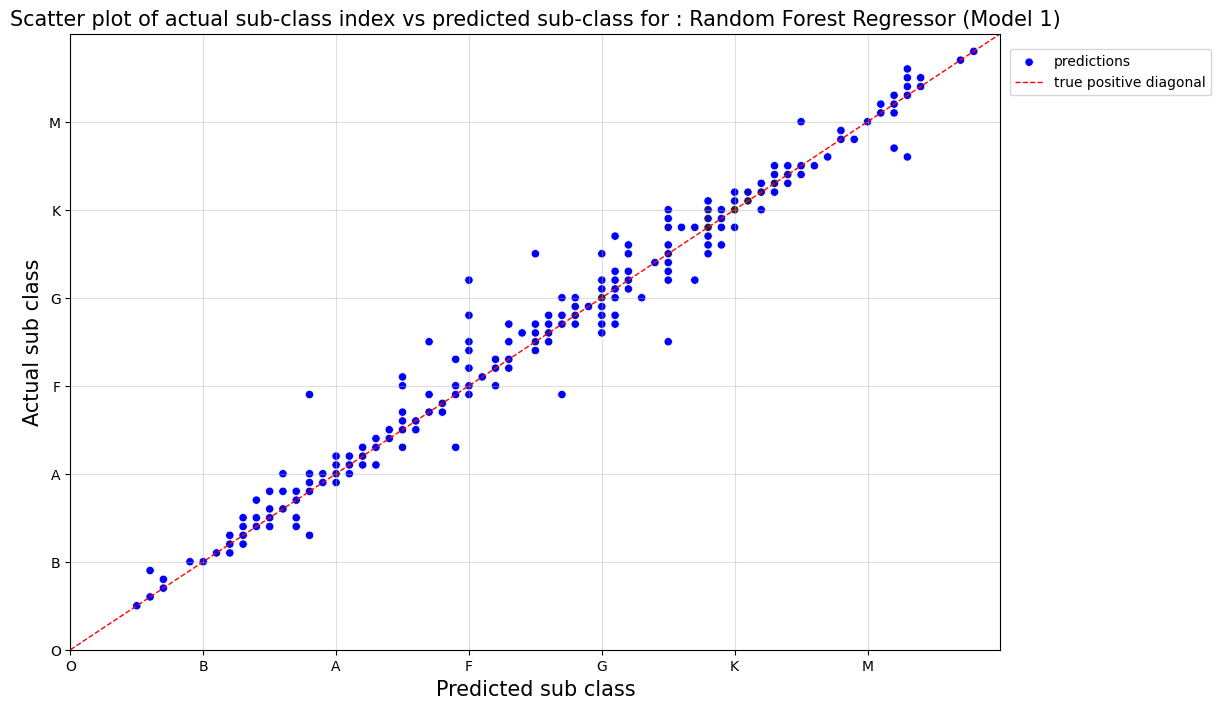

In [223]:
plot_scatter_plot(y_test, y_preds_test_rf1, 'Random Forest Regressor (Model 1)')

##### Hyperparameter tuning - Random Forest Regressor

There are some hyperparameters that may be tuned to improve the model accuracy. 
The most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features).
<br>
The hyperparameters that will be tuned as part of this research project are: <br>
- a) **n_estimators** : the number of decision trees in the forest
- b) **max_depth** : the maximum depth of each decision tree in the forest
- c) **max_features** : max number of features considered for splitting a node
- d) **min_samples_split**: min number of data points placed in a node before the node is split
- e) **min_samples_leaf**: min number of data points allowed in a leaf node



In [ ]:
##defining hyperparameter space to iterate through - might want to outline reason for below choices
param_grid = {'n_estimators':[10, 100, 200, 500, 1000], #number of trees (default = 100)
              'max_depth': [None, 5, 10, 20, 50], #max depth of tree (default = None)
              'max_features': ['sqrt', 'log2'],  #num features to consider when looking for best split
              'min_samples_leaf': [1, 2, 4] , 
              'min_samples_split': [2, 5, 10]
              } 

#Create a random forest regressor
rf = RandomForestRegressor()

#running gridSearch on params, with the default k-fold cross validation set to 3
grid_search_rf = GridSearchCV(estimator=rf, 
                              param_grid=param_grid, 
                              cv=3,  # 3-fold cross-validation
                              verbose=0) 

#Fit the grid search object to the data
grid_search_rf.fit(X_train, y_train)

In [ ]:
## Create a variable for the best model
best_rf = grid_search_rf.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  grid_search_rf.best_params_)

In [197]:
rf_reg2 = RandomForestRegressor(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                              min_samples_leaf=1, max_features='sqrt', random_state=42)

In [198]:
rf_reg2.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=500,
                      random_state=42)

In [199]:
rf2_reg_metrics, y_preds_train_rf_reg2, y_preds_test_rf_reg2 = get_metrics(rf_reg2, 
                                                          X_train, X_test, y_train, y_test, 
                                                          class_type='reg')

In [200]:
rf2_reg_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"RandomForestRegressor(max_depth=10, max_featur...",0.417431,0.425019,0.992449,1.050459,1.050459


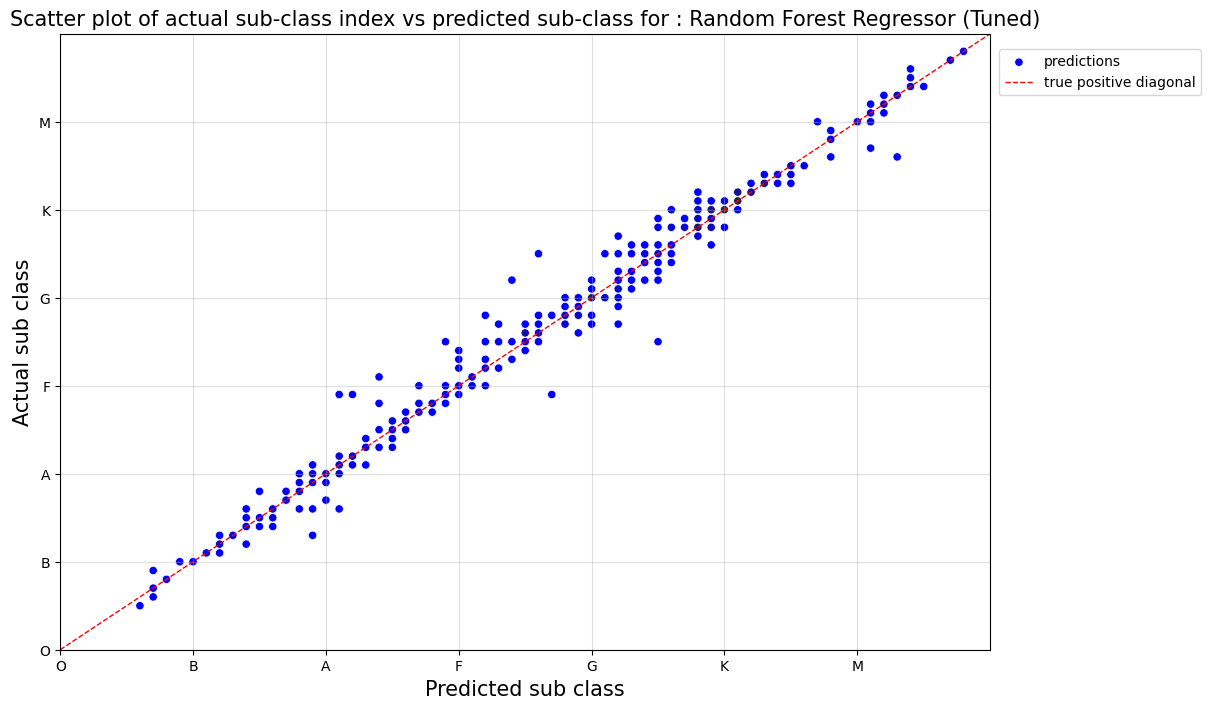

In [224]:
plot_scatter_plot(y_test, y_preds_test_rf_reg2, 'Random Forest Regressor (Tuned)')

## 3.2.1 Using balanced dataset

In [202]:
##load in cleaned and processed balanced data
balanced_df = pd.read_csv('../data/derived_tables/X_y_data/sub_bal.csv', index_col=0)

In [203]:
#splitting into independent/input (X) and dependent/target (Y) variables
X_bal = balanced_df.loc[:, balanced_df.columns != 'sub_class']
y_bal = balanced_df.loc[:, 'sub_class']

In [204]:
y_bal = y_bal.values

In [205]:
#splitting the data into training and testing (80% used for training, 20% for testing)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, 
                                                                    test_size = 0.2, 
                                                                    random_state = 1)

In [206]:
X_train_bal.shape, X_test_bal.shape, y_train_bal.shape, y_test_bal.shape

((1740, 3508), (436, 3508), (1740,), (436,))

In [207]:
rf_reg_bal = RandomForestRegressor(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                              min_samples_leaf=1, max_features='sqrt', random_state=42)

In [208]:
rf_reg_bal.fit(X_train_bal, y_train_bal)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=500,
                      random_state=42)

In [209]:
rfbal_reg_metrics, y_preds_train_rf_regbal, y_preds_test_rf_regbal = get_metrics(rf_reg_bal, 
                                                          X_train_bal, X_test, y_train_bal, y_test, 
                                                          class_type='reg')

In [210]:
rfbal_reg_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,"RandomForestRegressor(max_depth=10, max_featur...",0.594037,0.594673,0.995984,0.658257,0.658257


------------
# 4. Performing Stratified K-fold Cross Validation on all Models

In [167]:
def get_cross_val_score(model_name, X, y):
    
    s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    f1, accuracy, qwk, mae, average_error = [], [], [], [], []
    
    #creating the train/test split
    for train_index, test_index in s_kfold.split(X, y):
        #splitting training/testing
        X_train, X_test, y_train, y_test= X.iloc[train_index], X.iloc[test_index],  y[train_index], y[test_index]
        
        #initialising models
        if model_name == 'svm':    
            model = SVC(C=100, gamma=0.01, kernel='rbf')
        elif model_name == 'svm_bal':
            model = SVC(C=100, gamma=0.01, kernel='rbf')
        elif model_name == 'svm_reg':
             model = SVR(C=100, gamma=0.001, kernel='rbf', epsilon = 0.1)
        elif model_name == 'svm_reg_bal':
             model = SVR(C=100, gamma=0.001, kernel='rbf', epsilon = 0.1)
        elif model_name == 'rf':
            model = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                               min_samples_leaf=1, max_features='sqrt', random_state=42)
        elif model_name == 'rf_bal':
            model = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                               min_samples_leaf=1, max_features='sqrt', random_state=42)
        elif model_name == 'rf_reg':
            model = RandomForestRegressor(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                               min_samples_leaf=1, max_features='sqrt', random_state=42)
        elif model_name == 'rf_reg_bal':
            model = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split=2, 
                               min_samples_leaf=1, max_features='sqrt', random_state=42)
        #training the model using X_train, y_train
        model.fit(X_train, y_train)
        
        #making predictions from the model on the train and test data
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)

        #if ordinal classification (i.e. regression used) the predictions need to be converted to class lables
        if model_name[-3:] == 'reg':
            #reshaping predictions in a 1D array
            y_preds_train = y_preds_train.flatten()
            y_preds_test = y_preds_test.flatten()
            #converting continuous predictions to predicted class labels
            y_preds_train = np.round(y_preds_train).astype(int)
            #clipping to ensure predicted class is within the range of available classes
            y_preds_train = np.clip(y_preds_train, 0, len(class_order) - 1)

            y_preds_test = np.round(y_preds_test).astype(int)
            y_preds_test = np.clip(y_preds_test, 0, len(class_order) - 1)
    
        #calculating metrics
        #precision
        f1.append(metrics.f1_score(y_test, y_preds_test, average='weighted'))
        #accuracy
        accuracy.append(metrics.accuracy_score(y_test, y_preds_test))
        #quadratic weighted kappa
        qwk.append(metrics.cohen_kappa_score(y_test, y_preds_test, weights='quadratic'))
        #mean absolute error
        mae.append(metrics.mean_absolute_error(y_test, y_preds_test))
        #getting the class error for test set
        average_error.append(np.mean(abs(y_test - y_preds_test)))
        
    
    model_metrics = pd.DataFrame({'model':[model_name], 
                                  'accuracy':[np.mean(accuracy)], 
                                  'f1_score':[np.mean(f1)],
                                  'QWK':[np.mean(qwk)], 
                                  'MAE':[np.mean(mae)],
                                  'sp_class_error':[np.mean(average_error)]})
    return model_metrics

In [33]:
#get_cross_val_score('svm_reg_bal', X_bal, y_bal)

In [85]:
#get_cross_val_score('rf_reg_bal', X_bal, y_bal)

In [168]:
#running for all rf models
rf_df = get_cross_val_score('rf', X, y)
rf_reg_df = get_cross_val_score('rf_reg', X, y)
rf_bal_df = get_cross_val_score('rf_bal', X_bal, y_bal)
rf_bal_reg_df = get_cross_val_score('rf_reg_bal', X_bal, y_bal)

In [169]:
#running for all rf models
svm_df = get_cross_val_score('svm', X, y)
svm_reg_df = get_cross_val_score('svm_reg', X, y)
svm_bal_df = get_cross_val_score('svm_bal', X_bal, y_bal)
svm_bal_reg_df = get_cross_val_score('svm_reg_bal', X_bal, y_bal)

In [170]:
#concatenating all results to create one dataframe
ml_comparison_df = pd.concat([rf_df, rf_reg_df, rf_bal_df,
                              svm_df, svm_reg_df, svm_bal_df, svm_bal_reg_df, rf_reg_bal_df])
ml_comparison_df = ml_comparison_df.reset_index().drop(columns='index')

In [173]:
ml_comparison_df

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,rf,0.494316,0.505249,0.989518,1.022479,1.022479
1,rf_reg,0.453673,0.488007,0.991230,1.012841,1.012841
2,rf_bal,0.552345,0.544333,0.992080,0.895732,0.895732
3,svm,0.529816,0.522997,0.985308,1.025240,1.025240
4,svm_reg,0.421102,0.468858,0.992360,1.012841,1.012841
5,svm_bal,0.632345,0.659926,0.995403,0.704970,0.704970
6,svm_reg_bal,0.423255,0.472922,0.992458,0.991743,0.991743
7,rf_reg_bal,0.456336,0.498910,0.990974,1.026684,1.026684


In [172]:
#saving dataframe to be used in comparison notebook
ml_comparison_df.to_csv('../data/derived_tables/model_comparisons/ml_sub_class.csv')

# 5. Saving models

In [78]:
# Save models
dump(svm_bal, filename='saved_models/svm_bal.py')
dump(svm_2, filename='saved_models/svm.py')

['saved_models/svm.py']